# Exploring and Plotting BOSS Spectra with their Alternative Model Fits

## Learning Goals
By the end of this tutorial, you will:
- Know how to retrieve SDSS spectrum files and alternive model fits (as fit by IDLSPEC2D spec1d pipeline)

## Introduction
There are some circumstances where the BOSS spec1d pipeline does not provide a very good redshift or where it could not decide between two redshift values. However, it fits a large number of templates and provides the best fit result for each template, as well as their reduced $\chi^2$. The resultingredshifts (and corresponding models) of all of the other fits can be retreived using the ZALL extension in the specFull/specLite files or the spZall files (and the model template files stored within the IDLspec2D repository). Here we discuss how to retreive the alternative model redshift, and build corresponding the synthetic model spectra from the templates files.

### Imports
This tutorial requires three commonly used python packages, and an SDSS specific package
- `numpy` for doing large array operations
- `matplotlib` for plotting
- `astropy` for reading fits files and tables (and optionally used to download the supplemental files)
- `os` used for accessing environmental variables (optional if not using astropy to download the supplemental files)
- `sdss_access` for download the sdss data and building the file paths (this can be manually down if desired, but this is not shown here)

Missing packages can be installed via `pip install numpy matplotlib astropy sdss-access`

#### **Note!**
If you already have `sdss_access` installed but have trouble with these file types, try upgrading to the latest version `pip install --upgrade sdss-access sdss-tree`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Row
from astropy.io import fits
from astropy.utils.data import download_file
import os

from sdss_access import Access


## Obtaining/Building the Alternative Synthetic Model Spectra 
The Alternative Synthetic Model Spectra are not stored in any of the standard pipeline products. However, the parameters required to build them (using the model templates provided in the IDLspec2D repositiory) are stored within pipeline outputs. Below is the python port of the IDL function of the same name (from IDLSPEC2D; IDLSPEC2D > v6_2_1 includes this python function, but it was not included before that).

The function, synthspec, takes a row of the spZall file, the log-lambda array of the target, and optionally the location of the templates, and returns the model spectra evaluated to the loglamda wavelenth grid of the target. If the eigendir (location of templates) is not defined, it first tries to use the IDLSPEC2D_DIR environmental variable to find them, and if thats not set, then it downloads the required template from the Github repo. 

In [2]:
def synthspec(zans, loglam, eigendir=None):
    """
    Generate a synthetic spectrum using SDSS templates and redshifted eigenspectra. 
    This is a python port of the idl (IDLSPEC2D) function of the same name

    Parameters
    ----------
    zans : astropy.table.Row or dict-like
        A row from an Astropy Table (typically from SDSS fitting output), containing:
        - 'TFILE': template filename
        - 'TCOLUMN': array of column indices used in the eigentemplates
        - 'NPOLY': degree of additive polynomial terms used in the fit
        - 'THETA': coefficients used to combine eigentemplates and polynomial terms
        - 'Z': redshift of the object

    loglam : np.ndarray
        Array of log10(wavelength) values to which the spectrum should be interpolated.

    eigendir : str, optional
        Local path to the eigentemplates directory. If not provided, the templates will be downloaded
        from the SDSS GitHub repository.

    Returns
    -------
    newflux : np.ndarray
        The synthetic flux interpolated to the input `loglam` grid, accounting for redshift.
        If no template is available, returns an array of zeros with the same length as `loglam`.

    Notes
    -----
    - If the template file (`TFILE`) is not specified or empty, the function returns a zero flux array.
    - Polynomial terms up to degree `NPOLY` are optionally included in the spectrum model.
    - The final model is redshifted using the provided `Z` value and interpolated to the desired loglam grid.

    """

    if eigendir is None:
        # Try using the local IDLSPEC2D to get templates
        eigendir = os.getenv('IDLSPEC2D_DIR', default=None)
        if eigendir is not None: 
            eigendir = os.path.join(eigendir,'templates')

    tfile = str(zans['TFILE']).strip()
    if tfile == '':
        print('No Template')
        return np.zeros(len(loglam), dtype=np.float32)
        
    run1d = str(zans['RUN1D']).strip()

    if eigendir is not None:
        # Use local templates 
        model = os.path.join(eigendir, tfile)
    else:
        # Download requested template file
        try:
            baseurl = f'https://raw.githubusercontent.com/sdss/idlspec2d/refs/tags/{run1d}/templates/{tfile}'
            model = download_file(baseurl, cache=True, pkgname='boss_drp')
        except:
            try:
                baseurl = f'https://raw.githubusercontent.com/sdss/idlspec2d/refs/heads/{run1d}/templates/{tfile}'
                model = download_file(baseurl, cache=True, pkgname='boss_drp')
            except:
                baseurl = f'https://raw.githubusercontent.com/sdss/idlspec2d/refs/heads/master/templates/{tfile}'
                model = download_file(baseurl, cache=True, pkgname='boss_drp')                
    try:
        with fits.open(model, ignore_missing_end=True) as hdul:
            # Read the Template file
            starflux = hdul[0].data
            shdr = hdul[0].header
            has_data = starflux is not None and starflux.size > 1
            if not has_data:
                print('Invalid Template File')
                return np.zeros(len(loglam), dtype=np.float32)

            try:
                starloglam0 = shdr['COEFF0']
                stardloglam = shdr['COEFF1']
            except:
                print('Missing Wavelenth Coeffients in Template file')
                return np.zeros(len(loglam), dtype=np.float32)
    except Exception as e:
        print('Error reading Template')
        print(f'{type(e).__name__}: {e}')
        return np.zeros(len(loglam), dtype=np.float32)

    # Reshape and select relevant columns
    starflux = starflux.T if starflux.ndim == 2 else starflux[:, np.newaxis]
    starflux = starflux[:, np.array(zans['TCOLUMN'])[np.where(zans['TCOLUMN'] != -1)[0]]]

    # Add polynomial terms if required
    if zans['NPOLY'] != 0:
        x = np.arange(starflux.shape[0], dtype=np.float32) / starflux.shape[0]
        pa =  np.vstack([x**i for i in range(zans['NPOLY'])]).T  # shape (npix, npoly)
        starflux = np.hstack([starflux, pa])

    # Apply coefficients to get synthetic flux
    synflux = starflux @ zans['THETA'][:starflux.shape[1]]
    
    # Build loglam grid for template
    starloglam = starloglam0 + np.arange(starflux.shape[0]) * stardloglam

    # Redshift and interpolate
    newflux = np.interp(loglam, starloglam + np.log10(1 + zans['Z']), synflux)

    return newflux

## Obtaining and Plotting the SDSS-V Spectra with Alternative model
Below is an example of obtaining, reading, and plotting an SDSS-V (RUN2D >= 6.0.1) Spectra file with both its primary and alternative model.

If running this notebook on sciserver, `access.remote` may fail. Comment out `access.remote` through `access.reset` and just use `access.full` to get the local file path.

In [3]:
catalogid = 27021597842439106
mjd = 60095
fieldid = 101202

access = Access(release='DR19', verbose=False)
run2d = 'v6_1_3' # The Run2d version of the BOSS Pipeline used for DR19

access.remote()
access.add('specLite', run2d=run2d, fieldid = fieldid, mjd = mjd, catalogid=catalogid)
access.set_stream()
access.commit()
access.reset()

specFile = access.full('specLite', run2d=run2d, fieldid=fieldid, mjd = mjd, catalogid=catalogid)
print(f"{specFile} Exists: {access.exists('',full=specFile)}")


Progress:   0%|          | 0/1 [00:00<?, ?files/s, n_files=1, n_streams=1]

SDSS_ACCESS> Done!
/uufs/chpc.utah.edu/common/home/sdss50/dr19/spectro/boss/redux/v6_1_3/spectra/lite/101202/60095/spec-101202-60095-27021597842439106.fits Exists: True


In [4]:
spectra = fits.getdata(specFile, 'COADD')
spAll = fits.getdata(specFile,'SPALL')
Zall_targ = fits.getdata(specFile,'ZALL')
Table(Zall_targ)

FIELD,TILE,MJD,TARGET_INDEX,CATALOGID,SDSS_ID,FIBERID_LIST,RUN2D,RUN1D,OBJTYPE,FIBER_RA,FIBER_DEC,PLUG_RA,PLUG_DEC,CLASS,SUBCLASS,Z,Z_ERR,RCHI2,DOF,RCHI2DIFF,TFILE,TCOLUMN,NPOLY,THETA,THETA_COVAR,VDISP,VDISP_ERR,VDISPZ,VDISPZ_ERR,VDISPCHI2,VDISPNPIX,VDISPDOF,WAVEMIN,WAVEMAX,WCOVERAGE,ZWARNING,SN_MEDIAN,SN_MEDIAN_ALL,CHI68P,FRACNSIGMA,FRACNSIGHI,FRACNSIGLO,SPECTROFLUX,SPECTROFLUX_IVAR,SPECTROSYNFLUX,SPECTROSYNFLUX_IVAR,SPECTROSKYFLUX,ANYANDMASK,ANYORMASK,SPEC1_G,SPEC1_R,SPEC1_I,SPEC2_G,SPEC2_R,SPEC2_I
int32,int32,int32,int32,int64,int64,str7,str6,str6,str16,float64,float64,float64,float64,str6,str19,float32,float32,float32,int32,float32,str24,int32[10],int32,float32[10],"float32[10,10]",float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32[5],float32,float32,float32[10],float32[10],float32[10],float32[5],float32[5],float32[5],float32[5],float32[5],int32,int32,float32,float32,float32,float32,float32,float32
101202,0,60095,180,27021597842439106,68995788,119 119,v6_1_3,v6_1_3,science,285.8111565410277,65.12902804991552,nan,nan,QSO,BROADLINE,0.5166281,8.8180954e-05,0.79904187,4513,2.227911,spEigenQSO-58596.fits,0 .. 9,0,0.02138605 .. -0.02664858,1.4665879e-09 .. 2.02933e-06,0.0,0.0,0.0,0.0,0.0,0.0,0,3619.9285,10332.371,0.4523,0,5.8534417 .. 7.142995,11.357151,0.8487062,0.24408579 .. 0.0,0.12403272 .. 0.0,0.12005306 .. 0.0,82.644325 .. 70.831276,0.05728464 .. 0.049960647,62.111496 .. 70.75695,0.12136683 .. 0.07636316,71.02664 .. 184.35002,84410368,256835584,1.3282832,6.2918587,3.7958698,0.0,0.0,0.0
101202,0,60095,180,27021597842439106,68995788,119 119,v6_1_3,v6_1_3,science,285.8111565410277,65.12902804991552,nan,nan,GALAXY,,0.9124515,0.00021946062,3.026953,4516,0.0063238144,spEigenGal-56436.fits,0 .. -1,3,-0.0315115 .. 0.0,1.3828154e-05 .. 0.0,850.0,-3.0,0.0,0.0,2645.162,1200.0,1056,3619.9285,10332.371,0.4523,4,5.8534417 .. 7.142995,11.357151,0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.05728464 .. 0.049960647,0.0 .. 0.0,0.12136683 .. 0.07636316,0.0 .. 0.0,84410368,256835584,1.3282832,6.2918587,3.7958698,0.0,0.0,0.0
101202,0,60095,180,27021597842439106,68995788,119 119,v6_1_3,v6_1_3,science,285.8111565410277,65.12902804991552,nan,nan,GALAXY,,0.9171356,0.00019593276,3.0332768,4516,0.0931046,spEigenGal-56436.fits,0 .. -1,3,-0.047172636 .. 0.0,1.3839743e-05 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3619.9285,10332.371,0.4523,0,5.8534417 .. 7.142995,11.357151,0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.05728464 .. 0.049960647,0.0 .. 0.0,0.12136683 .. 0.07636316,0.0 .. 0.0,84410368,256835584,1.3282832,6.2918587,3.7958698,0.0,0.0,0.0
101202,0,60095,180,27021597842439106,68995788,119 119,v6_1_3,v6_1_3,science,285.8111565410277,65.12902804991552,nan,nan,QSO,,1.0649701,0.0005128066,3.1263814,4513,0.00699234,spEigenQSO-58596.fits,0 .. 9,0,0.014231999 .. 0.046974313,1.2605423e-09 .. 3.007719e-06,0.0,0.0,0.0,0.0,0.0,0.0,0,3619.9285,10332.371,0.4523,4,5.8534417 .. 7.142995,11.357151,0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.05728464 .. 0.049960647,0.0 .. 0.0,0.12136683 .. 0.07636316,0.0 .. 0.0,84410368,256835584,1.3282832,6.2918587,3.7958698,0.0,0.0,0.0
101202,0,60095,180,27021597842439106,68995788,119 119,v6_1_3,v6_1_3,science,285.8111565410277,65.12902804991552,nan,nan,QSO,,1.2176032,0.00033940477,3.1333737,4513,0.030988216,spEigenQSO-58596.fits,0 .. 9,0,0.0124671785 .. 0.002895194,8.0286144e-10 .. 3.7565494e-06,0.0,0.0,0.0,0.0,0.0,0.0,0,3619.9285,10332.371,0.4523,4,5.8534417 .. 7.142995,11.357151,0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.05728464 .. 0.049960647,0.0 .. 0.0,0.12136683 .. 0.07636316,0.0 .. 0.0,84410368,256835584,1.3282832,6.2918587,3.7958698,0.0,0.0,0.0
101202,0,60095,180,27021597842439106,68995788,119 119,v6_1_3,v6_1_3,science,285.8111565410277,65.12902804991552,nan,nan,QSO,,1.6645188,0.00027568208,3.164362,4513,0.024287462,spEigenQSO-58596.fits,0 .. 9,0,0.008893823 .. 0.01691912,1.7290694e-10 .. 3.4429695e-06,0.0,0.0,0.0,0.0,0.0,0.0,0,3619.9285,10332.371,0.4523,4,5.853441

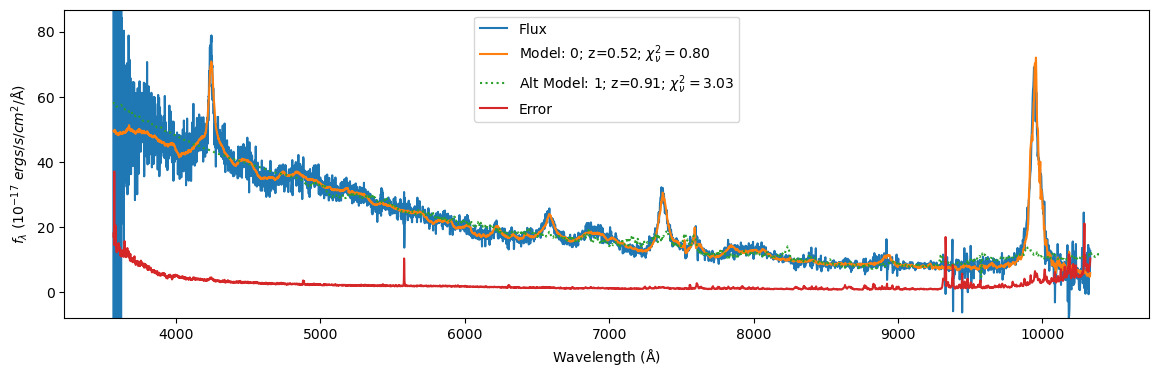

In [5]:
znum = 1 # zero indexed

plt.figure(figsize=(14,4))
wave = np.power(10, spectra['LOGLAM'])
mask = (spectra['AND_MASK'] == 0)
plt.plot(wave[mask], spectra['FLUX'][mask], label ='Flux')

label = "Model: {znum}; z={z:.2f}; $\\chi_\\nu^2={rchi2:.2f}$"

plt.plot(wave[mask], spectra['MODEL'][mask],
         label = label.format(znum=0,z=spAll['Z'][0],rchi2=spAll['RCHI2'][0]))


plt.plot(wave, synthspec(Zall_targ[znum], spectra['LOGLAM'], eigendir=None), ls = ':', 
        label = "Alt "+ label.format(znum=znum,z=Zall_targ[znum]['Z'],
                                     rchi2=Zall_targ[znum]['RCHI2']))

error = np.full_like(spectra['IVAR'].data, np.nan)
error[spectra['IVAR'] > 0]  = 1.0/np.sqrt(spectra['IVAR'][spectra['IVAR'] > 0])
plt.plot(wave[mask], error[mask], label='Error')
plt.ylim(np.min(spectra['FLUX'][mask][np.where(wave[mask]>3800)[0]]),
         1.1*np.max(spectra['FLUX'][mask][np.where(wave[mask]>3800)[0]]))
plt.ylabel(r'$f_\lambda~(10^{-17}~ergs/s/cm^2/\mathrm{\AA})$')
plt.xlabel(r'Wavelength $(\mathrm{\AA})$')
plt.legend()
plt.show()

## Obtaining and Plotting Pre-SDSS-V Spectra with Alternative model
Below is an example of obtaining, reading, and plotting an SDSS-IV Spectra file with both its primary and alternative model. In SDSS-IV (RUN2D <= v5_13_2), the specLite and specFull files did not contain the ZALL, so it is necessary to access it from the spZall file instead. Additionally, the `specFull` and `specLite` were called `spec` and `spec-lite`, and some of the required keywords in `sdss_access` are different

In [9]:
fiberid = 10
mjd = 57106
plateid = 7340

access = Access(release='DR17', verbose=False)
run2d = 'v5_13_2' # The Run2d version of the BOSS Pipeline used for DR17

access.remote()
access.add('spec-lite', run2d=run2d, plateid = plateid, mjd = mjd, fiberid=fiberid)
access.add('spZall', run2d=run2d, run1d=run2d, plateid=plateid, mjd = mjd)
access.set_stream()
access.commit()
access.reset()

specFile = access.full('spec-lite', run2d=run2d, plateid = plateid, mjd = mjd, fiberid=fiberid)
print(f"{specFile} Exists: {access.exists('',full=specFile)}")

spZallFile = access.full('spZall', run2d=run2d, run1d=run2d, plateid=plateid, mjd = mjd)
print(f"{spZallFile} Exists: {access.exists('',full=spZallFile)}")

Progress:   0%|          | 0/2 [00:00<?, ?files/s, n_files=2, n_streams=2]

SDSS_ACCESS> Done!
/uufs/chpc.utah.edu/common/home/sdss50/dr17/eboss/spectro/redux/v5_13_2/spectra/lite/7340/spec-7340-57106-0010.fits Exists: True
/uufs/chpc.utah.edu/common/home/sdss50/dr17/eboss/spectro/redux/v5_13_2/7340/v5_13_2/spZall-7340-57106.fits Exists: True


In [7]:
spectra = fits.getdata(specFile, 'COADD')
spAll = fits.getdata(specFile,'SPALL')

spZall = Table.read(spZallFile,1)
spZall_targ = spZall[(spZall['FIBERID']==fiberid)]
spZall_targ

PLATE,TILE,MJD,FIBERID,RUN2D,RUN1D,OBJID,OBJTYPE,PLUG_RA,PLUG_DEC,CLASS,SUBCLASS,Z,Z_ERR,RCHI2,DOF,RCHI2DIFF,TFILE,TCOLUMN,NPOLY,THETA,THETA_COVAR,VDISP,VDISP_ERR,VDISPZ,VDISPZ_ERR,VDISPCHI2,VDISPNPIX,VDISPDOF,WAVEMIN,WAVEMAX,WCOVERAGE,ZWARNING,SN_MEDIAN,SN_MEDIAN_ALL,CHI68P,FRACNSIGMA,FRACNSIGHI,FRACNSIGLO,SPECTROFLUX,SPECTROFLUX_IVAR,SPECTROSYNFLUX,SPECTROSYNFLUX_IVAR,SPECTROSKYFLUX,ANYANDMASK,ANYORMASK,SPEC1_G,SPEC1_R,SPEC1_I,SPEC2_G,SPEC2_R,SPEC2_I
int32,int32,int32,int32,bytes7,bytes7,int32[5],bytes16,float64,float64,bytes6,bytes19,float32,float32,float32,int32,float32,bytes24,int32[10],int32,float32[10],"float32[10,10]",float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32[5],float32,float32,float32[10],float32[10],float32[10],float32[5],float32[5],float32[5],float32[5],float32[5],int32,int32,float32,float32,float32,float32,float32,float32
7340,15910,57106,10,v5_13_2,v5_13_2,3712 .. 100,SPECTROPHOTO_STD,215.88634000000002,52.634655,STAR,F3/F5V (30743),-0.00039913345,6.546535e-06,1.8991747,4350,6.683651,spEigenStar-55734.fits,56 .. -1,4,47.61027 .. 0.0,0.07937908 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3601.6375,10337.131,0.4355,0,24.031927 .. 48.189957,53.531708,0.9991111,0.31986222 .. 0.0011481056,0.17451206 .. 0.0,0.14535017 .. 0.0011481056,113.82309 .. 394.08588,1.1645232 .. 1.6072257,110.584465 .. 394.58902,5.902484 .. 2.6994438,8.837707 .. 95.84193,92274688,265224192,17.8765,52.8939,42.1128,20.1358,57.2146,42.958
7340,15910,57106,10,v5_13_2,v5_13_2,3712 .. 100,SPECTROPHOTO_STD,215.88634000000002,52.634655,STAR,F2III (89254),-0.00044416595,7.432444e-06,2.2103121,4350,6.372514,spEigenStar-55734.fits,54 .. -1,4,36.973557 .. 0.0,0.05012351 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3601.6375,10337.131,0.4355,0,24.031927 .. 48.189957,53.531708,0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,1.1645232 .. 1.6072257,0.0 .. 0.0,5.902484 .. 2.6994438,0.0 .. 0.0,92274688,265224192,17.8765,52.8939,42.1128,20.1358,57.2146,42.958
7340,15910,57106,10,v5_13_2,v5_13_2,3712 .. 100,SPECTROPHOTO_STD,215.88634000000002,52.634655,STAR,F2V (33256),-0.0004143466,6.7580118e-06,2.2561219,4350,6.326704,spEigenStar-55734.fits,55 .. -1,4,40.67742 .. 0.0,0.06117346 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3601.6375,10337.131,0.4355,0,24.031927 .. 48.189957,53.531708,0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,1.1645232 .. 1.6072257,0.0 .. 0.0,5.902484 .. 2.6994438,0.0 .. 0.0,92274688,265224192,17.8765,52.8939,42.1128,20.1358,57.2146,42.958
7340,15910,57106,10,v5_13_2,v5_13_2,3712 .. 100,SPECTROPHOTO_STD,215.88634000000002,52.634655,STAR,F6II (61295),-0.0004133646,7.017288e-06,2.260286,4350,6.3225393,spEigenStar-55734.fits,58 .. -1,4,40.04821 .. 0.0,0.059381444 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3601.6375,10337.131,0.4355,0,24.031927 .. 48.189957,53.531708,0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,1.1645232 .. 1.6072257,0.0 .. 0.0,5.902484 .. 2.6994438,0.0 .. 0.0,92274688,265224192,17.8765,52.8939,42.1128,20.1358,57.2146,42.958
7340,15910,57106,10,v5_13_2,v5_13_2,3712 .. 100,SPECTROPHOTO_STD,215.88634000000002,52.634655,STAR,F0IV (81937),-0.00046872822,7.568015e-06,2.3718188,4350,6.211007,spEigenStar-55734.fits,51 .. -1,4,34.993977 .. 0.0,0.04617321 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3601.6375,10337.131,0.4355,0,24.031927 .. 48.189957,53.531708,0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,1.1645232 .. 1.6072257,0.0 .. 0.0,5.902484 .. 2.6994438,0.0 .. 0.0,92274688,265224192,17.8765,52.8939,42.1128,20.1358,57.2146,42.958
7340,15910,57106,10,v5_13_2,v5_13_2,3712 .. 100,SPECTROPHOTO_STD,215.88634000000002,52.634655,STAR,F6III (61064),-0.00040342665,7.181535e-06,2.5748246,4350,6.0080013,spEigenStar-55734.fits,59 .. -1,4,37.729305 .. 0.0,0.055467244 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3601.6375,10337.131,0.4355,0,24.031927 .. 48.189957,53.531708,0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,1.1645232 .. 1.6072257,0.0 .. 0.0,5.902484 .. 2.6994438,0.0 .. 0.0,92274688,265224192,17.8765,52.8939,42.1128,20.1358,57.2146,42.958
7340,15910

PLATE,TILE,MJD,FIBERID,RUN2D,RUN1D,OBJID,OBJTYPE,PLUG_RA,PLUG_DEC,CLASS,SUBCLASS,Z,Z_ERR,RCHI2,DOF,RCHI2DIFF,TFILE,TCOLUMN,NPOLY,THETA,THETA_COVAR,VDISP,VDISP_ERR,VDISPZ,VDISPZ_ERR,VDISPCHI2,VDISPNPIX,VDISPDOF,WAVEMIN,WAVEMAX,WCOVERAGE,ZWARNING,SN_MEDIAN,SN_MEDIAN_ALL,CHI68P,FRACNSIGMA,FRACNSIGHI,FRACNSIGLO,SPECTROFLUX,SPECTROFLUX_IVAR,SPECTROSYNFLUX,SPECTROSYNFLUX_IVAR,SPECTROSKYFLUX,ANYANDMASK,ANYORMASK,SPEC1_G,SPEC1_R,SPEC1_I,SPEC2_G,SPEC2_R,SPEC2_I
int32,int32,int32,int32,bytes7,bytes7,int32[5],bytes16,float64,float64,bytes6,bytes19,float32,float32,float32,int32,float32,bytes24,int32[10],int32,float32[10],"float32[10,10]",float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32[5],float32,float32,float32[10],float32[10],float32[10],float32[5],float32[5],float32[5],float32[5],float32[5],int32,int32,float32,float32,float32,float32,float32,float32
7340,15910,57106,10,v5_13_2,v5_13_2,3712 .. 100,SPECTROPHOTO_STD,215.88634000000002,52.634655,STAR,F2III (89254),-0.00044416595,7.432444e-06,2.2103121,4350,6.372514,spEigenStar-55734.fits,54 .. -1,4,36.973557 .. 0.0,0.05012351 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3601.6375,10337.131,0.4355,0,24.031927 .. 48.189957,53.531708,0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,1.1645232 .. 1.6072257,0.0 .. 0.0,5.902484 .. 2.6994438,0.0 .. 0.0,92274688,265224192,17.8765,52.8939,42.1128,20.1358,57.2146,42.958


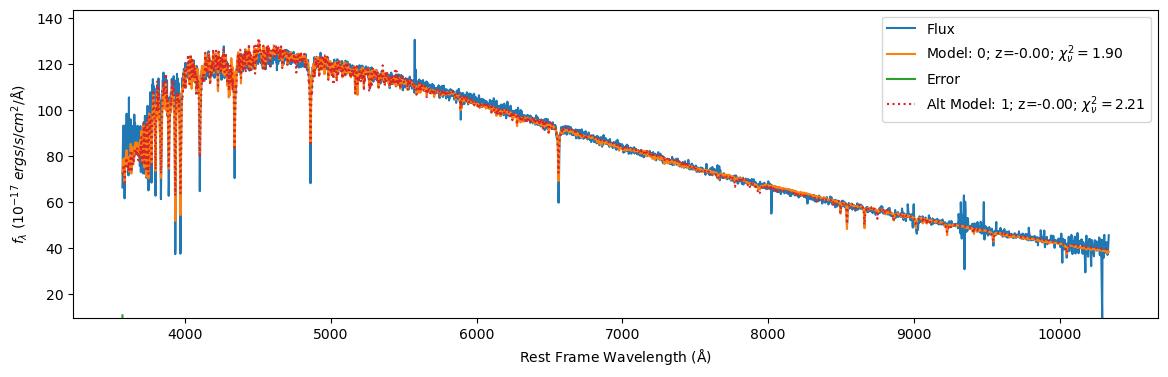

In [8]:
znum = 1 #(zero indexed)
display(spZall_targ[[znum]])
plt.figure(figsize=(14,4))
wave = np.power(10, spectra['LOGLAM'])
mask = (spectra['AND_MASK'] == 0)

label = "Model: {znum}; z={z:.2f}; $\\chi_\\nu^2={rchi2:.2f}$"

plt.plot(wave[mask], spectra['FLUX'][mask], label ='Flux')
plt.plot(wave[mask], spectra['MODEL'][mask], 
         label = label.format(znum=0,z=spAll['Z'][0],rchi2=spAll['RCHI2'][0]))
error = np.full_like(spectra['IVAR'].data, np.nan)
error[spectra['IVAR'] > 0]  = 1.0/np.sqrt(spectra['IVAR'][spectra['IVAR'] > 0])
plt.plot(wave[mask], error[mask], label='Error')
plt.plot(wave, synthspec(spZall_targ[znum], spectra['LOGLAM'], eigendir=None), ls = ':', 
        label = "Alt "+ label.format(znum=znum,z=spZall_targ[znum]['Z'],
                                     rchi2=spZall_targ[znum]['RCHI2']))
plt.ylim(np.min(spectra['FLUX'][mask][np.where(wave[mask]>3800)[0]]),
         1.1*np.max(spectra['FLUX'][mask][np.where(wave[mask]>3800)[0]]))
plt.ylabel(r'$f_\lambda~(10^{-17}~ergs/s/cm^2/\mathrm{\AA})$')
plt.xlabel(r'Rest Frame Wavelength $(\mathrm{\AA})$')
plt.legend()
plt.show()

## About this notebook
This notebook was created to illustrate how to find and use the various Coadds of the SDSS-V BOSS spectra

**Authors**: Sean Morrison

**Last Update**: 2025 April 16

If you use astropy for published research, please cite the authors. Follow this link for more information about citing astropy: [Citing `astropy`](https://www.astropy.org/acknowledging.html) 

And of course please [cite](https://sdss.org/collaboration/citing-sdss/) SDSS when you use our data.